# 1）Import necessary libraries

In [1]:
# 套件導入
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from nltk import pos_tag
from nltk.corpus import wordnet
import os
import codecs
import glob
import mailbox
import textwrap
import typing
import tkinter as tk
from tkinter import messagebox, scrolledtext
from autocorrect import Speller

# 2. Data preprocessing

In [2]:
# 根目錄中的數據資料夾名稱
DATADIR = "spamassassin-public-corpus"

# 構建資料夾的完整路徑
SPAM_2 = os.path.join(DATADIR, "spam_2", "spam_2")
HARD_HAM = os.path.join(DATADIR, "hard_ham", "hard_ham")
EASY_HAM = os.path.join(DATADIR, "easy_ham", "easy_ham")
SPAM = os.path.join(DATADIR, "spam")

# 確認資料夾是否存在
for path in [SPAM_2, HARD_HAM, EASY_HAM, SPAM]:
    if os.path.exists(path):
        print(f"資料夾 {path} 存在")
    else:
        print(f"資料夾 {path} 不存在，請確認路徑和資料夾名稱")

資料夾 spamassassin-public-corpus\spam_2\spam_2 存在
資料夾 spamassassin-public-corpus\hard_ham\hard_ham 存在
資料夾 spamassassin-public-corpus\easy_ham\easy_ham 存在
資料夾 spamassassin-public-corpus\spam 不存在，請確認路徑和資料夾名稱


In [3]:
# 定義預處理函數
strip_tags = CountVectorizer().build_tokenizer()

def _exists_encoding(enc: str) -> bool:
    try:
        codecs.lookup(enc)
    except LookupError:
        return False
    return True

def _get_charsets(msg):
    charset = ""
    for c in msg.get_charsets():
        if c is not None and _exists_encoding(c):
            charset = c
    return charset or "utf-8"

def get_body(data: str) -> str:
    msg = mailbox.mboxMessage(data)
    subject = msg["Subject"] or ""
    while msg.is_multipart():
        msg = msg.get_payload()[0]
    t = msg.get_payload(decode=True)
    return "\n".join((subject, t.decode(_get_charsets(msg), errors="ignore")))

def strip_whitespace(data: str, n: typing.Optional[int] = None) -> str:
    return " ".join(data.split()[:n])

def strip_all_lint(raw: str) -> str:
    body = get_body(raw)
    tokens = word_tokenize(body)
    return " ".join(tokens)

def get_filepath(kind: str, num: int) -> str:
    assert not (kind == SPAM and num == 0), "使用 num=1 從 spam 集中獲取。"
    filepaths = glob.glob(os.path.join(kind, f"*{num}*"))
    print(f"查找的文件模式: {os.path.join(kind, f'*{num}*')}")
    print(f"找到的文件: {filepaths}")
    if not filepaths:
        raise FileNotFoundError(f"未找到符合 {num} 的文件在目錄 {kind} 中")
    return filepaths[0]

def get_cleaned_corpus(file: str) -> str:
    with open(file, errors="backslashreplace") as f:
        return strip_all_lint(f.read())


In [4]:
def peek_into_data(data: str, *, l: int = 0, h: typing.Optional[int] = 200) -> None:
    print("="*10, "The raw data:")
    print(data[l:h])
    print("="*10, "\n")
    body = get_body(data)
    print("="*10, "The body of email:")
    print(body[l:h])
    print("="*10, "\n")
    cleaned = strip_all_lint(body)
    print("="*10, "The body, void of any HTML tags:")
    print(cleaned[l:h])
    print("="*10, "\n")
    print("="*10, "The cleaned data, void of any whitespace or newline (wrapped):")
    print(textwrap.fill(strip_whitespace(cleaned[l:h]), 79))
    print("="*10)

In [5]:
# 讀取一個樣本文件進行查看
with open(get_filepath(SPAM_2, 201), errors="backslashreplace") as file:
    raw = file.read()
peek_into_data(raw)

查找的文件模式: spamassassin-public-corpus\spam_2\spam_2\*201*
找到的文件: ['spamassassin-public-corpus\\spam_2\\spam_2\\00021.07d9ab534bbfba9020145659008a3a14', 'spamassassin-public-corpus\\spam_2\\spam_2\\00045.c1a84780700090224ce6ab0014b20183', 'spamassassin-public-corpus\\spam_2\\spam_2\\00201.e74734c7cd89b7c55989d585f72b358a', 'spamassassin-public-corpus\\spam_2\\spam_2\\00228.238a0547cbbd70a024d7d4376707f201', 'spamassassin-public-corpus\\spam_2\\spam_2\\00385.2017c0f15243b44ef7d52ca0a5f1ecaa', 'spamassassin-public-corpus\\spam_2\\spam_2\\00500.87320162ab5b79f67978406cf909c3d1', 'spamassassin-public-corpus\\spam_2\\spam_2\\00501.32679091b0520132ad888ef3b134ce48', 'spamassassin-public-corpus\\spam_2\\spam_2\\00609.4dfe7912017772587dc62fecc3cf6553', 'spamassassin-public-corpus\\spam_2\\spam_2\\00944.fbc64dd9cbcbc201d82256821978f318', 'spamassassin-public-corpus\\spam_2\\spam_2\\01186.a323fbbb1fbb04737201f2eb73b7e663', 'spamassassin-public-corpus\\spam_2\\spam_2\\01201.471d379a63806032b2c397883

In [6]:
def get_list_of_paths(
    seed: typing.Optional[int] = None,
    *,
    max_num: typing.Optional[int] = None,
) -> typing.Tuple[typing.List[str], typing.List[str]]:
    """
    獲取所有ham和spam的數據路徑。
    將``seed``設置為``None``意味著隨機數生成器將不具有決定性。
    
    返回(ham路徑, spam路徑)的元組。
    """
    rng = np.random.RandomState(seed)
    fetch = lambda kind: glob.glob(os.path.join(kind, "*.*"))

    all_ham = fetch(EASY_HAM) + fetch(HARD_HAM)
    all_spam = fetch(SPAM) + fetch(SPAM_2)

    try:
        all_spam.remove(
            os.path.join(
                SPAM,
                # 這個文件沒有用。
                "0000.7b1b73cf36cf9dbc3d64e3f2ee2b91f1",
            )
        )
    except ValueError:
        # 可能是在kaggle運行
        pass

    rng.shuffle(all_ham)
    rng.shuffle(all_spam)

    if max_num is not None:
        return all_ham[:max_num], all_spam[:max_num]

    # ``n`` 變成兩個列表中較短的長度
    if len(all_ham) > len(all_spam):
        return all_ham[:len(all_spam)], all_spam
    return all_ham, all_spam[:len(all_ham)]


In [7]:
# 步驟1：獲取隨機打亂的路徑列表。
ham, spam = get_list_of_paths(42)

# 打印ham和spam的數量
print(f"No. of hams: {len(ham)}\nNo. of spams: {len(spam)}")

No. of hams: 1396
No. of spams: 1396


In [8]:
# 步驟2和步驟3：將數據加載到內存並應用標籤（ham -> 1, spam -> 0）
ham_data = []
spam_data = []

# 加載ham數據並打印進度
print("Loading ham data...")
for i, path in enumerate(ham):
    if i % 100 == 0:
        print(f"Processing ham email {i}/{len(ham)}")
    ham_data.append((get_cleaned_corpus(path), 1))

ham_df = pd.DataFrame(ham_data, columns=["text", "label"])
print("Ham data loaded.")

# 加載spam數據並打印進度
print("Loading spam data...")
for i, path in enumerate(spam):
    if i % 100 == 0:
        print(f"Processing spam email {i}/{len(spam)}")
    spam_data.append((get_cleaned_corpus(path), 0))

spam_df = pd.DataFrame(spam_data, columns=["text", "label"])
print("Spam data loaded.")

# 合併數據
print("Combining data...")
df = pd.concat([spam_df, ham_df], ignore_index=True)
print("Data combined.")

# 檢查最後幾行
print("Data preview:")
print(df.tail())


Loading ham data...
Processing ham email 0/1396
Processing ham email 100/1396
Processing ham email 200/1396
Processing ham email 300/1396
Processing ham email 400/1396
Processing ham email 500/1396
Processing ham email 600/1396
Processing ham email 700/1396
Processing ham email 800/1396
Processing ham email 900/1396
Processing ham email 1000/1396
Processing ham email 1100/1396
Processing ham email 1200/1396
Processing ham email 1300/1396
Ham data loaded.
Loading spam data...
Processing spam email 0/1396
Processing spam email 100/1396
Processing spam email 200/1396
Processing spam email 300/1396
Processing spam email 400/1396
Processing spam email 500/1396
Processing spam email 600/1396
Processing spam email 700/1396
Processing spam email 800/1396
Processing spam email 900/1396
Processing spam email 1000/1396
Processing spam email 1100/1396
Processing spam email 1200/1396
Processing spam email 1300/1396
Spam data loaded.
Combining data...
Data combined.
Data preview:
                   

In [9]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import nltk  # 確保nltk已導入

# 初始化工具
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 定義詞形還原和移除停用詞函數
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]  # 保留字母字符
    tokens = [token for token in tokens if token not in stop_words]  # 移除停用詞
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # 詞形還原
    return " ".join(tokens)

# 應用到整個數據集
df["text"] = df["text"].apply(preprocess_text)

df.tail()


,text,label
2787,sun nabs storage startup buy pirus network rel...,1
2788,use base image delta image automated recovery ...,1
2789,internet archive bookmobile http opening argum...,1
2790,thanks gamix source rpm alsa stuff wish could ...,1
2791,winxpnews time patch window medium player html...,1


In [10]:
# 步驟4：將數據集拆分為訓練集和測試集。
train, test = train_test_split(df, stratify=df["label"])

# 打印訓練集的標籤分佈
print("Train dataset:", train["label"].value_counts(), sep="\n")

# 打印測試集的標籤分佈
print("Test dataset:", test["label"].value_counts(), sep="\n")

Train dataset:
label
1    1047
0    1047
Name: count, dtype: int64
Test dataset:
label
1    349
0    349
Name: count, dtype: int64


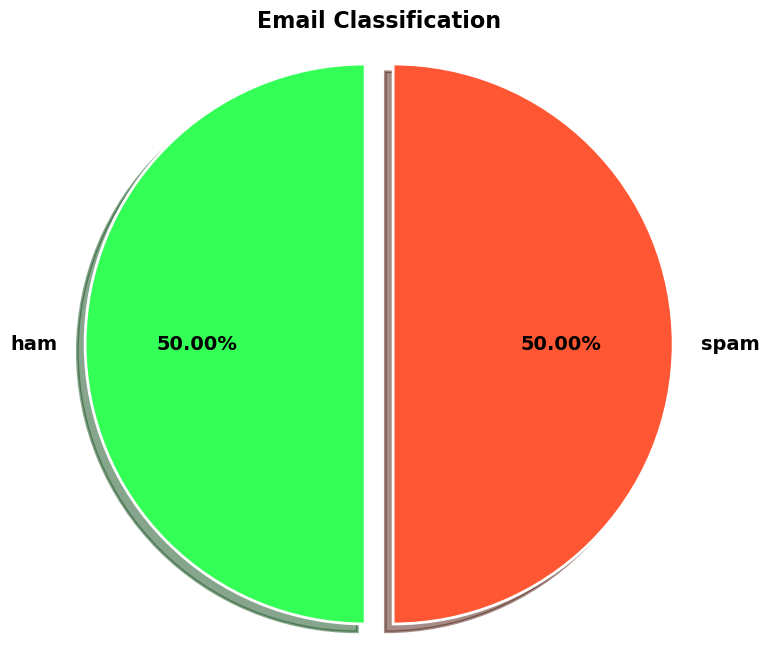

In [11]:
values = df["label"].value_counts().tolist()
labels = ['ham', 'spam']
colors = ['#33FF57', '#FF5733']
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white')
wedges, texts, autotexts = ax.pie(values, labels=labels, autopct='%0.2f%%', startangle=90, colors=colors, wedgeprops={'linewidth': 2, 'edgecolor': 'white'}, explode=explode, shadow=True)

for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

ax.set_title('Email Classification', fontsize=16, fontweight='bold')
ax.axis('equal')
plt.show()

# 3. Define text vectorization methods

In [12]:
# 特徵提取和建模
def vectorizer(X_train, X_test, min_df=0.0, max_df=1.0, max_features=30, method='count'):
    '''
    對正文部分進行特徵提取，兩種方法：count不考慮詞頻，term_frequency考慮詞頻
    '''
    if method == 'count':
        vectorizer = CountVectorizer(
            min_df=min_df, max_df=max_df, binary=False, ngram_range=(1, 3), max_features=max_features)
    elif method == 'term_frequency':
        vectorizer = TfidfVectorizer(
            min_df=min_df, max_df=max_df, use_idf=True, ngram_range=(1, 3), max_features=max_features)

    features_train = vectorizer.fit_transform(X_train).toarray()
    features_test = vectorizer.transform(X_test).toarray()
    features_name = vectorizer.get_feature_names_out()

    return vectorizer, features_name, features_train, features_test

# 4. Train and evaluate different vectorization methods

In [13]:
# 定義訓練和測試數據
train_message = train["text"]
test_message = test["text"]
train_category = train["label"]
test_category = test["label"]

results = []

for method in ['count', 'term_frequency']:
    vec, features_name, features_train, features_test = vectorizer(train_message, test_message, method=method)
    classifiers = [MultinomialNB(), BernoulliNB(), ComplementNB()]
    classifier_names = ['MultinomialNB', 'BernoulliNB', 'ComplementNB']
    if method == 'count':
        print('count方法')
    else:
        print('term_frequency方法')    
    for classifier, classifier_name in zip(classifiers, classifier_names):
        classifier.fit(features_train, train_category)
        y_pred = classifier.predict(features_test)
        accuracy = accuracy_score(y_true=test_category, y_pred=y_pred)
        precision = precision_score(y_true=test_category, y_pred=y_pred)
        recall = recall_score(y_true=test_category, y_pred=y_pred)
        f1 = f1_score(y_true=test_category, y_pred=y_pred)
        print(classifier_name + ':  ' + 'accuracy ' + str(accuracy) + '  precision ' + str(precision) + '  recall ' + str(recall) + '  f1 ' + str(f1))
        results.append((method, classifier_name, accuracy, precision, recall, f1))

results_df = pd.DataFrame(results, columns=['Method', 'Classifier', 'Accuracy', 'Precision', 'Recall', 'F1'])


count方法
MultinomialNB:  accuracy 0.7106017191977078  precision 0.6644295302013423  recall 0.8510028653295129  f1 0.7462311557788945
BernoulliNB:  accuracy 0.7077363896848138  precision 0.6375711574952562  recall 0.9627507163323782  f1 0.7671232876712328
ComplementNB:  accuracy 0.7106017191977078  precision 0.6644295302013423  recall 0.8510028653295129  f1 0.7462311557788945
term_frequency方法
MultinomialNB:  accuracy 0.6962750716332379  precision 0.6492374727668845  recall 0.8538681948424068  f1 0.7376237623762376
BernoulliNB:  accuracy 0.7077363896848138  precision 0.6375711574952562  recall 0.9627507163323782  f1 0.7671232876712328
ComplementNB:  accuracy 0.6962750716332379  precision 0.6492374727668845  recall 0.8538681948424068  f1 0.7376237623762376


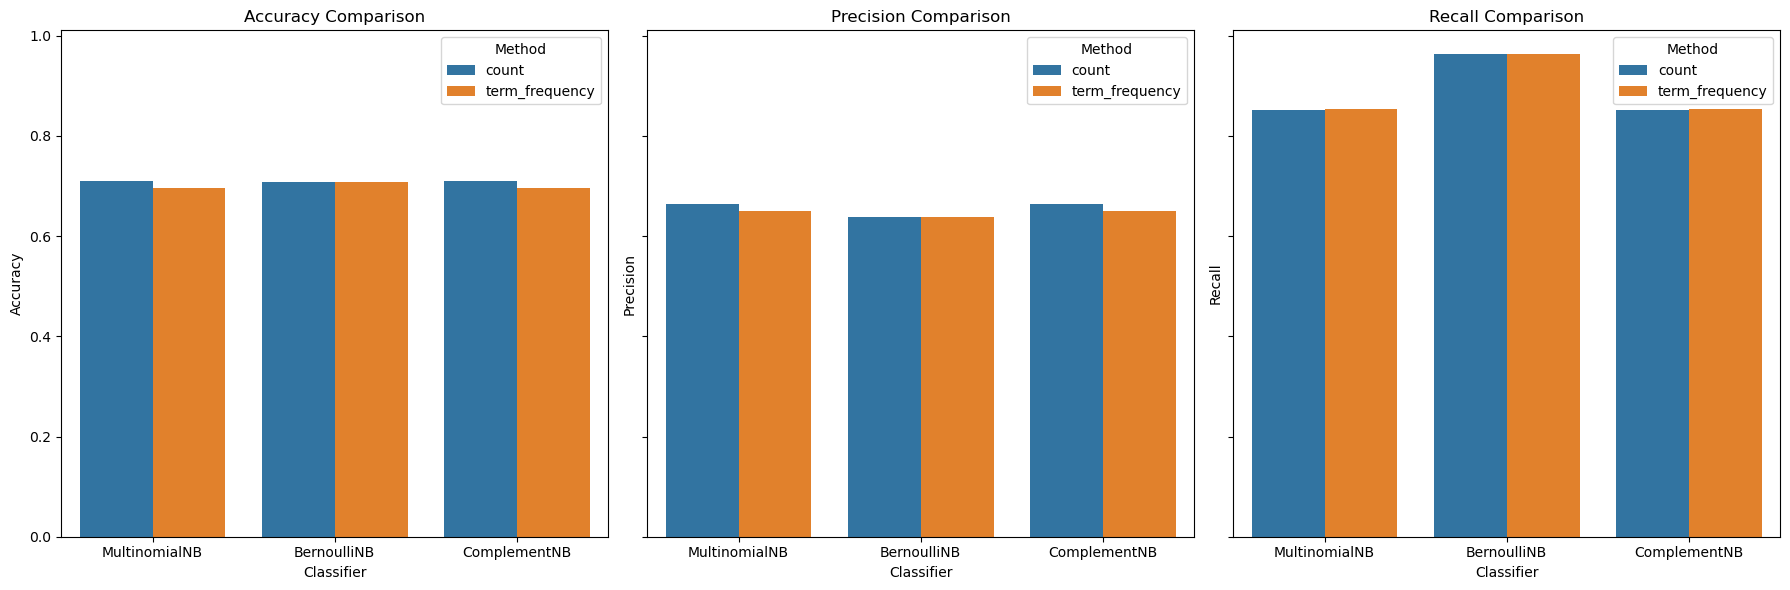

In [14]:
# 可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

metrics = ['Accuracy', 'Precision', 'Recall']
for i, metric in enumerate(metrics):
    sns.barplot(x='Classifier', y=metric, hue='Method', data=results_df, ax=axes[i])
    axes[i].set_title(f'{metric} Comparison')
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Classifier')

plt.tight_layout()
plt.show()


# 5. Train and evaluate with different numbers of features
### MultinomialNB + CountVectorizer

In [22]:
# 針對更高的特徵數目進行訓練和評估
max_features = [10, 30, 50, 70, 100, 300, 500, 1000, 1500, 2000, 3000, 4000, 5000]
accuracys = []
precisions = []
recalls = []

model2 = MultinomialNB()
for _max_feature in max_features:
    print('特徵數目：' + str(_max_feature))
    vec, features_name, features_train, features_test = vectorizer(
        train_message, test_message, max_features=_max_feature, method='count')
    
    model2.fit(features_train, train_category)
    y_pred = model2.predict(features_test)
    
    accuracy = accuracy_score(y_true=test_category, y_pred=y_pred)
    precision = precision_score(y_true=test_category, y_pred=y_pred)
    recall = recall_score(y_true=test_category, y_pred=y_pred)
    
    accuracys.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    print('accuracy ' + str(accuracy) + '  precision ' + str(precision) + '  recall ' + str(recall))


特徵數目：10
accuracy 0.6332378223495702  precision 0.6004319654427646  recall 0.7965616045845272
特徵數目：30
accuracy 0.7106017191977078  precision 0.6644295302013423  recall 0.8510028653295129
特徵數目：50
accuracy 0.7822349570200573  precision 0.7468671679197995  recall 0.8538681948424068
特徵數目：70
accuracy 0.8037249283667621  precision 0.7663316582914573  recall 0.8739255014326648
特徵數目：100
accuracy 0.833810888252149  precision 0.8157181571815718  recall 0.8624641833810889
特徵數目：300
accuracy 0.9283667621776505  precision 0.8986666666666666  recall 0.9656160458452722
特徵數目：500
accuracy 0.9312320916905444  precision 0.8929503916449086  recall 0.9799426934097422
特徵數目：1000
accuracy 0.9383954154727794  precision 0.9047619047619048  recall 0.9799426934097422
特徵數目：1500
accuracy 0.9398280802292264  precision 0.9007832898172323  recall 0.9885386819484241
特徵數目：2000
accuracy 0.9412607449856734  precision 0.9031413612565445  recall 0.9885386819484241
特徵數目：3000
accuracy 0.9541547277936963  precision 0.93188010899

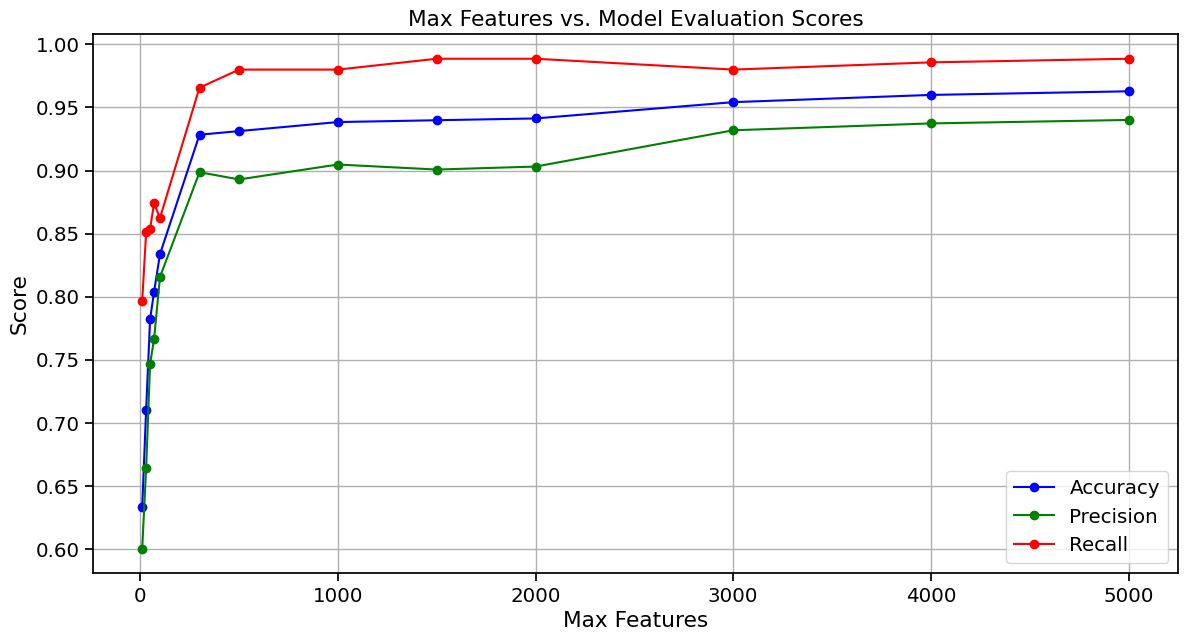

In [23]:
# 繪製性能變化圖
plt.figure(figsize=(14, 7))
plt.plot(max_features, accuracys, marker='o', label='Accuracy', color='blue')
plt.plot(max_features, precisions, marker='o', label='Precision', color='green')
plt.plot(max_features, recalls, marker='o', label='Recall', color='red')
plt.xlabel('Max Features')
plt.ylabel('Score')
plt.title('Max Features vs. Model Evaluation Scores')
plt.legend()
plt.grid(True)
plt.show()

# 6. Model training

In [24]:
# 獲取最好的特徵數目，假設為5000
best_max_feature = 5000

# 訓練最終模型
final_vectorizer, features_name, final_features_train, final_features_test = vectorizer(
    train_message, test_message, max_features=best_max_feature, method='count')

# 使用 MultinomialNB 模型
final_model = MultinomialNB()
final_model.fit(final_features_train, train_category)

# 檢查最終模型在測試集上的性能
y_pred = final_model.predict(final_features_test)
y_prob = final_model.predict_proba(final_features_test)[:, 1]
print("分類報告:")
print(classification_report(test_category, y_pred, target_names=['垃圾郵件', '正常郵件']))
print("混淆矩陣:")
print(confusion_matrix(test_category, y_pred))

分類報告:
              precision    recall  f1-score   support

        垃圾郵件       0.99      0.94      0.96       349
        正常郵件       0.94      0.99      0.96       349

    accuracy                           0.96       698
   macro avg       0.96      0.96      0.96       698
weighted avg       0.96      0.96      0.96       698

混淆矩陣:
[[327  22]
 [  4 345]]


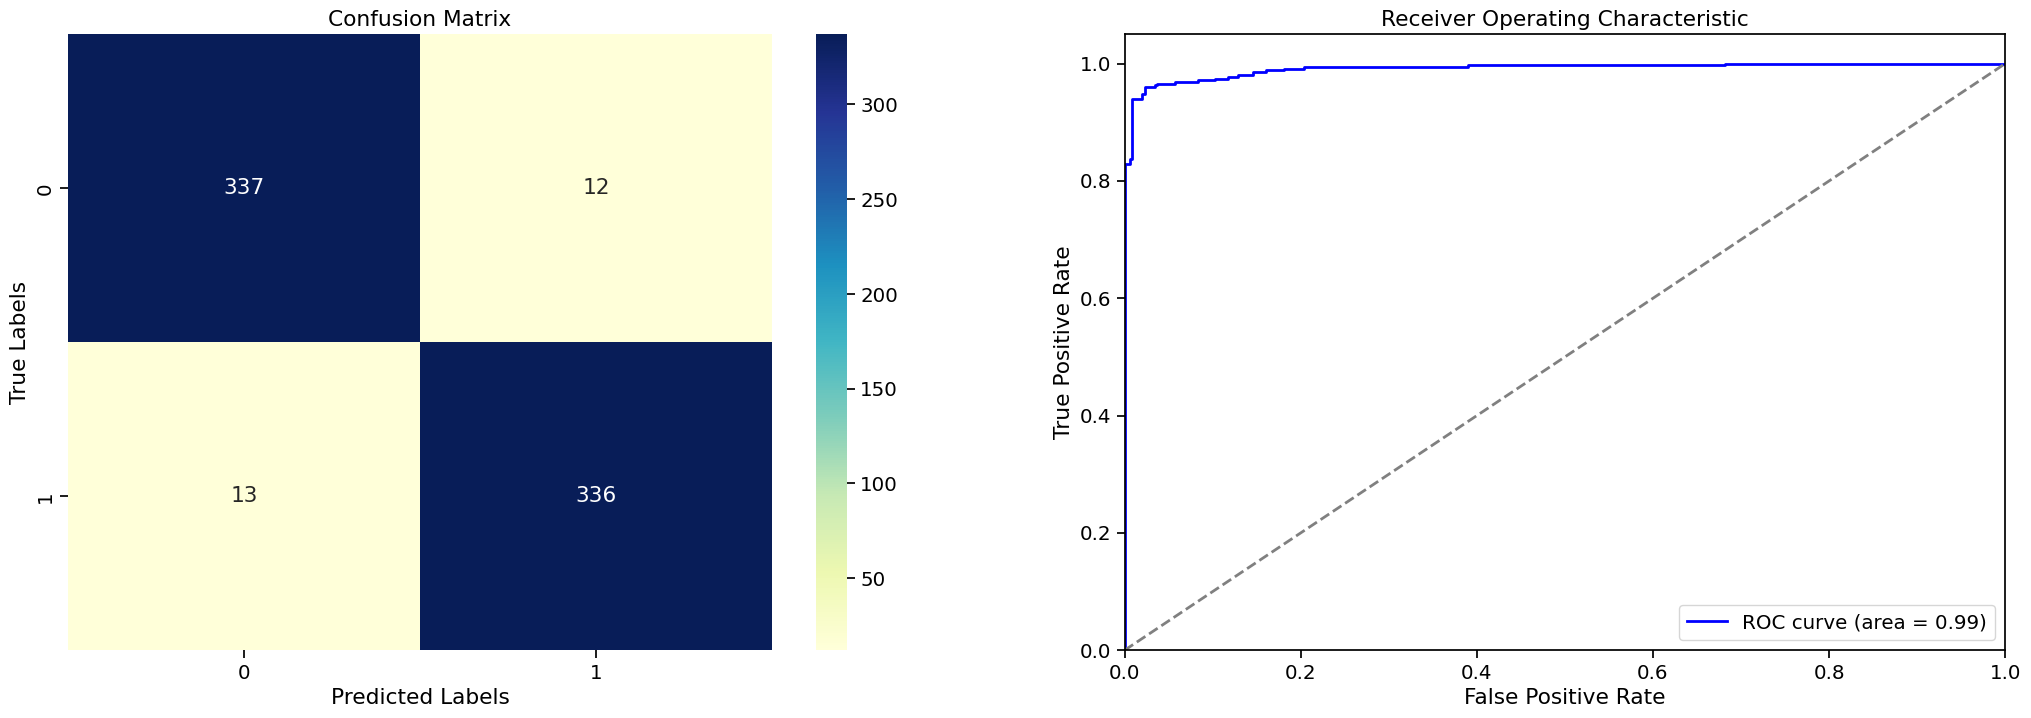

In [18]:
# 繪製混淆矩陣和 ROC 曲線
conf_matrix = confusion_matrix(test_category, y_pred)

sns.set_context('notebook', font_scale=1.3)
fig, ax = plt.subplots(1, 2, figsize=(25, 8))

# 混淆矩陣
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='YlGnBu', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

# 繪製 ROC 曲線
fpr, tpr, _ = roc_curve(test_category, y_prob)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='b', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_title('Receiver Operating Characteristic')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc="lower right")

plt.show()

# 7. Simple GUI implementation

In [25]:
# 增強預處理函數
def preprocess_input(text):
    spell = Speller()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [spell(word) for word in tokens if word.isalnum() and word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)

In [26]:
# GUI 部分
def classify_email():
    email_text = email_input.get("1.0", tk.END).strip()
    if not email_text:
        messagebox.showwarning("Input Error", "Please enter email text")
        return

    # 預處理輸入的電子郵件文本
    email_text_processed = preprocess_input(email_text)
    email_features = final_vectorizer.transform([email_text_processed]).toarray()
    
    # 預測
    prediction = final_model.predict(email_features)
    result = "Spam" if prediction[0] == 0 else "Ham"
    
    result_text.set(f"Result: {result}")

In [29]:
# 建立 GUI 界面
root = tk.Tk()
root.title("電子郵件分類器")

# 創建輸入框
email_label = tk.Label(root, text="輸入電子郵件文本:")
email_label.pack()

email_input = scrolledtext.ScrolledText(root, wrap=tk.WORD, width=60, height=10)
email_input.pack()

# 創建按鈕
classify_button = tk.Button(root, text="分類", command=classify_email)
classify_button.pack()

# 創建結果顯示區域
result_text = tk.StringVar()
result_label = tk.Label(root, textvariable=result_text, font=("Arial", 16))
result_label.pack()

root.mainloop()